In [99]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [114]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import math

#Check PyTorch version
torch.__version__

'2.4.0'

In [116]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 1
end = 20
step = 0.1
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * (X) + bias
X[:10], y[:10]

(tensor([[1.0000],
         [1.1000],
         [1.2000],
         [1.3000],
         [1.4000],
         [1.5000],
         [1.6000],
         [1.7000],
         [1.8000],
         [1.9000]]),
 tensor([[1.0000],
         [1.0700],
         [1.1400],
         [1.2100],
         [1.2800],
         [1.3500],
         [1.4200],
         [1.4900],
         [1.5600],
         [1.6300]]))

In [117]:
# For now, we'll just use a training and test set, 
# this means we'll have a dataset for our model 
# to learn on as well as be evaluated on.
# We can create them by splitting our X and y tensors.
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(152, 152, 38, 38)

In [118]:
def plot_predictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
    """
    Plot training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    #Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s = 4, label="Training data")
    #Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s = 4, label="Testing data")

    if predictions is not None:
        #Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    plt.legend(prop={"size":14})

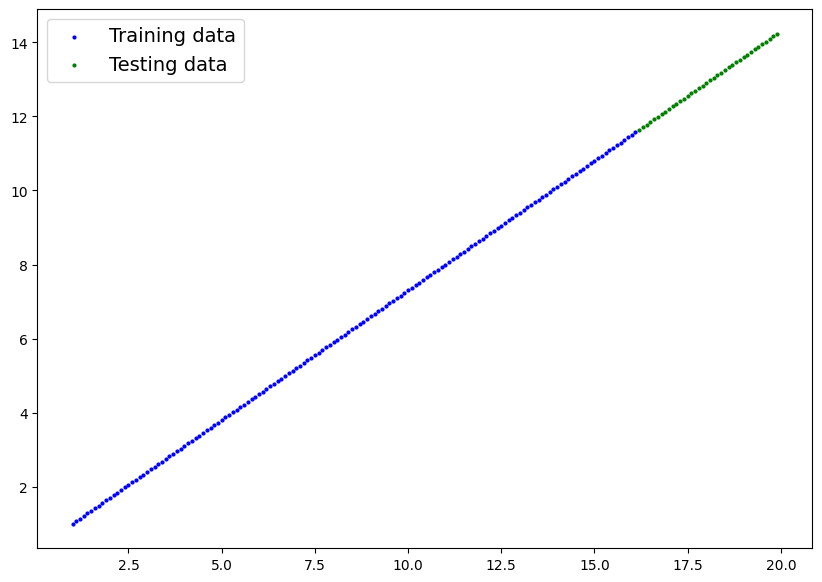

In [119]:
plot_predictions()

In [120]:
# 2. Build model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                dtype=torch.float),
                                    requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1,
                                             dtype=torch.float),
                                requires_grad=True)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [121]:
#Checking the contents of a PyTorch model
torch.manual_seed(42)

# Create an instance of the model 
# (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [122]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [123]:
# Making predictions using torch.inference_mode()
with torch.inference_mode():
    y_preds = model_0(X_test)


In [124]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 38
Number of predictions made: 38
Predicted values:
tensor([[5.5832],
        [5.6169],
        [5.6505],
        [5.6842],
        [5.7179],
        [5.7515],
        [5.7852],
        [5.8189],
        [5.8525],
        [5.8862],
        [5.9199],
        [5.9536],
        [5.9872],
        [6.0209],
        [6.0546],
        [6.0882],
        [6.1219],
        [6.1556],
        [6.1892],
        [6.2229],
        [6.2566],
        [6.2902],
        [6.3239],
        [6.3576],
        [6.3913],
        [6.4249],
        [6.4586],
        [6.4923],
        [6.5259],
        [6.5596],
        [6.5933],
        [6.6269],
        [6.6606],
        [6.6943],
        [6.7279],
        [6.7616],
        [6.7953],
        [6.8289]])


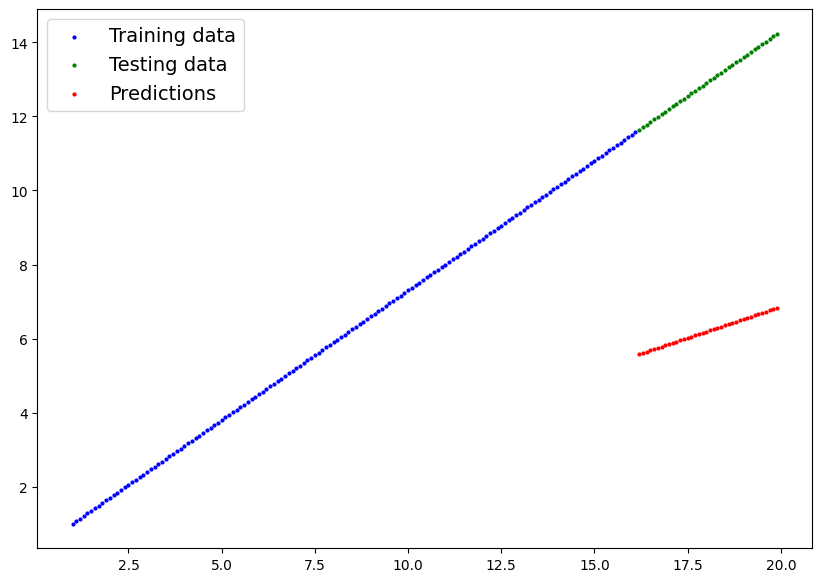

In [125]:
plot_predictions(predictions=y_preds)

In [126]:
y_test - y_preds

tensor([[6.0568],
        [6.0931],
        [6.1295],
        [6.1658],
        [6.2021],
        [6.2385],
        [6.2748],
        [6.3111],
        [6.3475],
        [6.3838],
        [6.4201],
        [6.4564],
        [6.4928],
        [6.5291],
        [6.5654],
        [6.6018],
        [6.6381],
        [6.6744],
        [6.7108],
        [6.7471],
        [6.7834],
        [6.8198],
        [6.8561],
        [6.8924],
        [6.9288],
        [6.9651],
        [7.0014],
        [7.0377],
        [7.0741],
        [7.1104],
        [7.1467],
        [7.1831],
        [7.2194],
        [7.2557],
        [7.2921],
        [7.3284],
        [7.3647],
        [7.4011]])

In [133]:
#Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

#Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)


In [134]:
torch.manual_seed(42)

epochs = 200

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training 

    # Put model in training mode (this is the default state of a model)
    model_0.train()
    
    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = model_0(X_test)
        
        # 2. Calculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        # Print out what's happening
        if epoch%10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
            

Epoch: 0 | MAE Train Loss: 3.277487277984619 | MAE Test Loss: 5.175653457641602 
Epoch: 10 | MAE Train Loss: 0.2694662809371948 | MAE Test Loss: 1.1263682842254639 
Epoch: 20 | MAE Train Loss: 0.21549159288406372 | MAE Test Loss: 1.2353439331054688 
Epoch: 30 | MAE Train Loss: 0.17663323879241943 | MAE Test Loss: 1.3135770559310913 
Epoch: 40 | MAE Train Loss: 0.14812584221363068 | MAE Test Loss: 1.370835304260254 
Epoch: 50 | MAE Train Loss: 0.12599490582942963 | MAE Test Loss: 1.4152170419692993 
Epoch: 60 | MAE Train Loss: 0.10545817017555237 | MAE Test Loss: 1.4563785791397095 
Epoch: 70 | MAE Train Loss: 0.0923294797539711 | MAE Test Loss: 1.482633113861084 
Epoch: 80 | MAE Train Loss: 0.07920069992542267 | MAE Test Loss: 1.5088878870010376 
Epoch: 90 | MAE Train Loss: 0.06607169657945633 | MAE Test Loss: 1.535142183303833 
Epoch: 100 | MAE Train Loss: 0.05978751927614212 | MAE Test Loss: 1.5476778745651245 
Epoch: 110 | MAE Train Loss: 0.053503476083278656 | MAE Test Loss: 1.5602

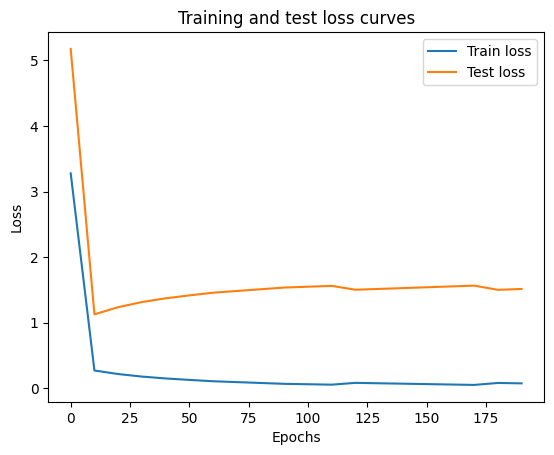

In [135]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label ="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [136]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.7041])), ('bias', tensor([0.1978]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [137]:
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[11.6046],
        [11.6750],
        [11.7454],
        [11.8158],
        [11.8863],
        [11.9567],
        [12.0271],
        [12.0975],
        [12.1679],
        [12.2383],
        [12.3087],
        [12.3791],
        [12.4496],
        [12.5200],
        [12.5904],
        [12.6608],
        [12.7312],
        [12.8016],
        [12.8720],
        [12.9424],
        [13.0129],
        [13.0833],
        [13.1537],
        [13.2241],
        [13.2945],
        [13.3649],
        [13.4353],
        [13.5057],
        [13.5762],
        [13.6466],
        [13.7170],
        [13.7874],
        [13.8578],
        [13.9282],
        [13.9986],
        [14.0691],
        [14.1395],
        [14.2099]])

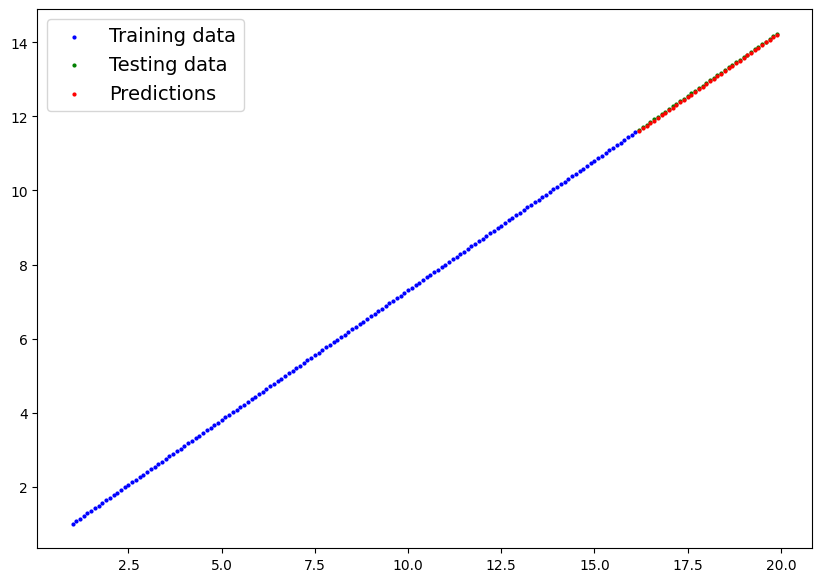

In [138]:
plot_predictions(predictions=y_preds)